In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import plotly.graph_objs as go
import plotly.express as px 

from kernel_sca_inducing_points import *

In [25]:

def DDM(mu, sigma, dt, total_time, key, trials):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps): 
            if jnp.abs(x[i, t]) < 1:
                normal_sample = random.normal(current_key, shape=())
                x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
                current_key, subkey = random.split(current_key)
            else:
                ls_RT.append(t)
                ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
                x = x.at[i, t:].set(jnp.sign(x[i, t]))
                break
    return x, ls_RT, ls_acc

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time = 100
trials = 150

ls_RTs = []
ls_accs = []
paths = jnp.zeros((trials, len(mu), int(total_time / dt) + 1))
for i in range(trials):
    key = random.PRNGKey(42 + i)
    path, ls_RT, ls_acc = DDM(mu, sigma, dt, total_time, key, trials) 
    paths = paths.at[i].set(path)
    ls_RTs.append(ls_RT)
    ls_accs.append(ls_acc)

accs = jnp.array(ls_accs)
RTs = jnp.array(ls_RTs)
paths = paths[:,:, :jnp.max(RTs)]
#paths_motion_on = paths[:,:, :jnp.min(RTs)]

# single_trial = False
# if single_trial:
#     paths_run = paths.reshape(-1, jnp.max(RTs))
# else:
#     paths_run = jnp.mean(paths, axis=0)#[jnp.newaxis,:,:]

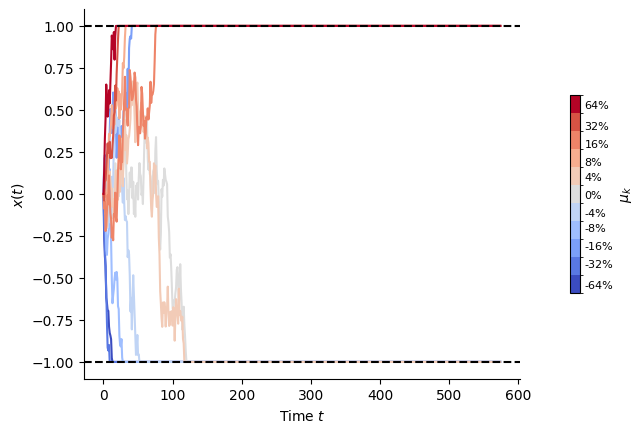

In [26]:

fig, ax = plt.subplots()
#times = np.linspace(0, total_time, int(total_time / dt) + 1)

boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(paths[3, i, :], color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [27]:
def parametric_curve_v(x, mu):
    val = len(mu)//2
    x_1 = x[:,:val][:, ::-1]
    x_2 = x[:,val+1:]
    return x_1, x_2

RTs_1, RTs_2 = parametric_curve_v(RTs, mu)
accs_1, accs_2 = parametric_curve_v(accs, mu)

val = len(mu)//2
RTs_p = (RTs_1 + RTs_2) /2 
RTs_p = jnp.concatenate((RTs[:,val][:,jnp.newaxis], RTs_p), axis=1)

p_correct_1 = (jnp.sum(accs_1 == 1, axis=0) / accs_1.shape[0]) * 100
p_correct_2 = (jnp.sum(accs_2 == 1, axis=0) / accs_2.shape[0]) * 100
p_correct = (p_correct_1 + p_correct_2) /2 
p_correct = jnp.concatenate((jnp.array([50]), p_correct), axis=0)

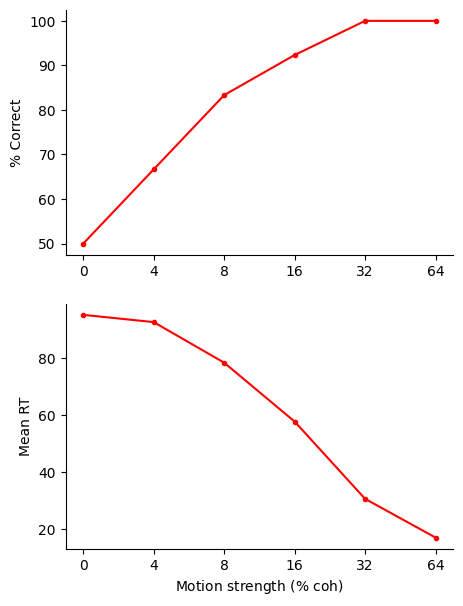

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(5,7))

axs[0].plot(p_correct, marker='.', color='r' )
axs[0].set_ylabel('% Correct')
axs[1].plot(jnp.mean(RTs_p, axis=0), marker='.', color='r')
axs[1].set_ylabel('Mean RT')
axs[1].set_xlabel('Motion strength ($\%$ coh)')
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ticks = np.arange(len(mu[val:]))  
    tick_labels = [f"{int(x * 100)}" for x in mu[val:]]  
    ax.set_xticks(ticks)  
    ax.set_xticklabels(tick_labels)  



In [29]:
def project(paths, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, 1))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                                        #(N',N)
    return jnp.einsum('dn,lknt->lkdt', proj_matrix, paths[:,:,jnp.newaxis,:])           #(trial, K, N=1, T)

def relu(x):
    return jnp.maximum(0, x)

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.05 ):
    trials, K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    epsilon_t = random.normal(key2, (trials, K, T, proj_dims)) * sigma  
    noise = jnp.einsum('lktd,nd->lknt', epsilon_t, B)             
    
    X += noise                                                   
    return X


neural_traces = relu(project(paths[:,:,:]))
neural_traces = neural_traces * 10

# noise = random.normal(key, (X.shape)) / 1000
# X += noise
key = random.PRNGKey(42)
key, subkey = random.split(key)
neural_traces = add_low_rank_noise(neural_traces, key, subkey)        #(trials, K, N, T)

X = jnp.mean( neural_traces, axis=0 )
#X = neural_traces.squeeze()
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)      

In [31]:
d = 3
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=300, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 16.512048721313477, S_ratio: 0.01647963374853134
Iteration 10, S: 85.38074493408203, S_ratio: 0.052867546677589417
Iteration 20, S: 198.41378784179688, S_ratio: 0.09847806394100189
Iteration 30, S: 503.51190185546875, S_ratio: 0.15995964407920837
Iteration 40, S: 768.922607421875, S_ratio: 0.145343616604805
Iteration 50, S: 1309.852783203125, S_ratio: 0.13382123410701752
Iteration 60, S: 2451.281494140625, S_ratio: 0.15008878707885742
Iteration 70, S: 3275.411865234375, S_ratio: 0.15811288356781006
Iteration 80, S: 4263.24365234375, S_ratio: 0.16454830765724182
Iteration 90, S: 3811.927978515625, S_ratio: 0.15253400802612305
Iteration 100, S: 3639.270263671875, S_ratio: 0.15508458018302917
Iteration 110, S: 6035.23046875, S_ratio: 0.1438053548336029
Iteration 120, S: 5390.72802734375, S_ratio: 0.15390993654727936
Iteration 130, S: 6206.3583984375, S_ratio: 0.1394166350364685
Iteration 140, S: 4892.29736328125, S_ratio: 0.14163225889205933
Iteration 150, S: 5592.734375, 

In [102]:

def plot_3D_K_coded(Y, elevation=30, azimuth=30):
    K, _,_=Y.shape
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d') 
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(K):
        x = Y[k, 0, :]
        y = Y[k, 1, :]
        z = Y[k, 2, :] 
       

        color = cmap(k / (K - 1)) 
        ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)

        #ax.view_init(elev=elevation, azim=azimuth)

    ax.set_xlabel('Dim. 1')
    ax.set_ylabel('Dim. 2')
    ax.set_zlabel('Dim. 3')
    ax.set_box_aspect(aspect=None, zoom=0.85)
    plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')
    

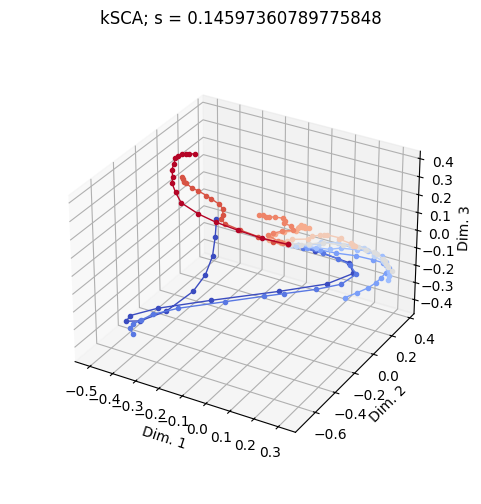

In [103]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]

plot_3D_K_coded(Y, elevation=10, azimuth=60)

# plot_3D(Y[:,:,:])
# plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

In [33]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

Iteration 0, S: 54.68159866333008, S_ratio: 1.7498248780611902e-05
Iteration 10, S: 57.753597259521484, S_ratio: 1.995385355257895e-05
Iteration 20, S: -11.263999938964844, S_ratio: -3.1284321266866755e-06
Iteration 30, S: 93.18399810791016, S_ratio: 2.3024158508633263e-05
Iteration 40, S: 21.913599014282227, S_ratio: 3.3596772937016794e-06
Iteration 50, S: 19.25119972229004, S_ratio: 2.3459840576833813e-06
Iteration 60, S: -31.12959861755371, S_ratio: -6.996814590820577e-06
Iteration 70, S: -32.56319808959961, S_ratio: -7.823466148693115e-06
Iteration 80, S: 17.20319938659668, S_ratio: 4.095225449418649e-06
Iteration 90, S: 39.93600082397461, S_ratio: 7.312172783713322e-06
Iteration 100, S: 153.19039916992188, S_ratio: 1.5486804841202684e-05
Iteration 110, S: 38.09280014038086, S_ratio: 3.988016942457762e-06
Iteration 120, S: -600.8831787109375, S_ratio: -5.301822238834575e-05
Iteration 130, S: 200.70399475097656, S_ratio: 1.4376405488292221e-05
Iteration 140, S: -334.23358154296875, 

Text(0.5, 1.0, 'SCA; s = -0.00010385896894149482')

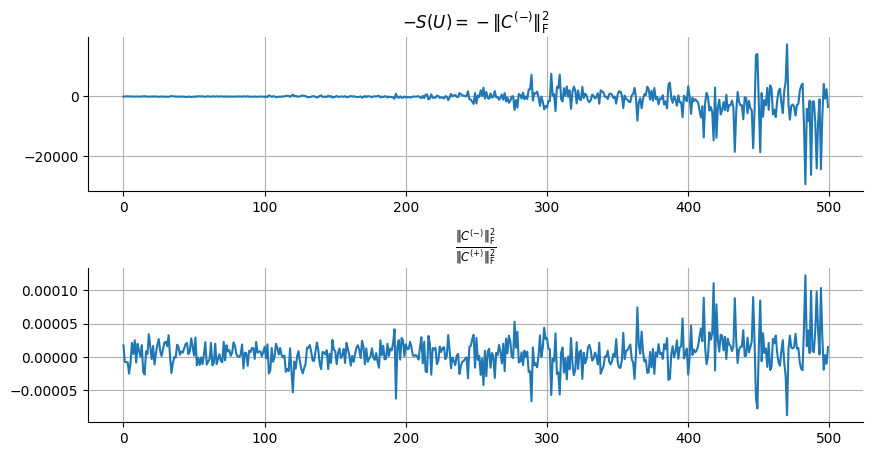

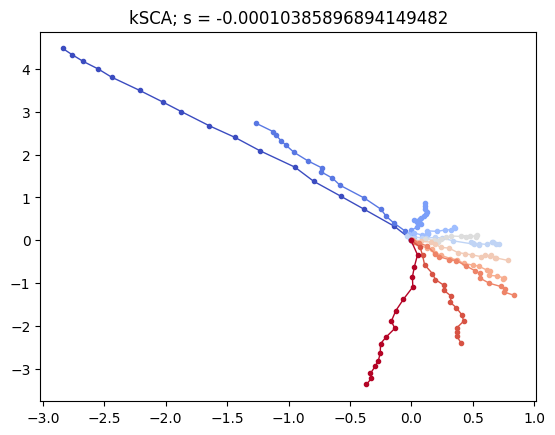

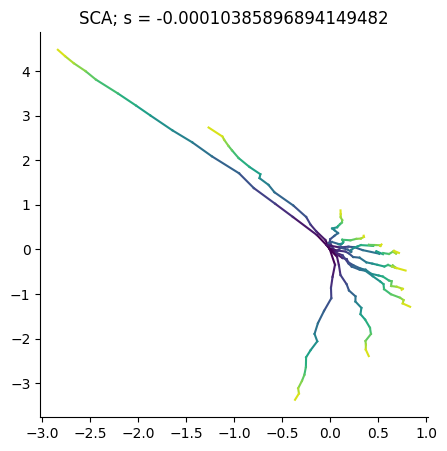

In [10]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))


for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_2D_K_coded(Y)

plot_2D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

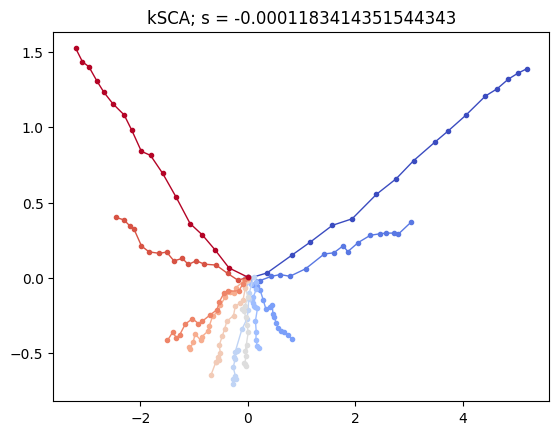

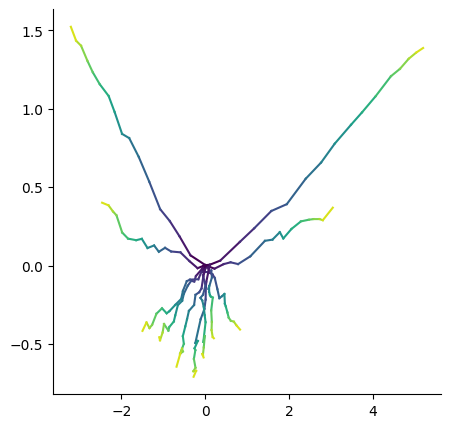

In [11]:
""" PCA """
def get_pca(X_train, X_test=None, test=False):
    X_pca_train = center(X_train).swapaxes(1,2).reshape(-1, N)

    num_pcs = 2
    pca = PCA(num_pcs)
    if test:
        X_pca_test = center(X_test).swapaxes(1,2).reshape(-1, N)
        Y_pca = pca.fit(X_pca_train).transform(X_pca_test)
    else:
        Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
    PCs = pca.components_
    Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
    return Y_pca, PCs

Y_pca, PCs = get_pca(X)

for i in range(Y_pca.shape[0]):
    Y_pca = Y_pca[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_2D_K_coded(jnp.array(Y_pca))

plot_2D(Y_pca)

In [45]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()